## Importing data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [2]:
random_seed = 42
df = pd.read_csv("data.csv")
evaluation = pd.read_csv("evaluation.csv")

### Converting columns of Country and Status to category type for encoding

In [3]:
df['Country'] = df['Country'].astype("category")
df['Status'] = df['Status'].astype("category")
df['Country'] = df['Country'].cat.codes
df['Status'] = df['Status'].cat.codes

evaluation['Country'] = evaluation['Country'].astype("category")
evaluation['Status'] = evaluation['Status'].astype("category")
evaluation['Country'] = evaluation['Country'].cat.codes
evaluation['Status'] = evaluation['Status'].cat.codes

### Splitting the dataset into training, validation, and testing sets

1. Split the dataset into training and the rest (40% for validation and testing)

2. Split the remaining dataset into validation (40% of the rest) and testing sets

3. Extract the 'Country' column for evaluation

4. Separate the target variable 'Life expectancy' from the features

In [4]:
Xtrain, Xrest = train_test_split(df, test_size=0.4, random_state=random_seed)

Xval, Xtest = train_test_split(Xrest, test_size=0.6, random_state=random_seed)

evaluation_country = evaluation["Country"]

ytrain = Xtrain["Life expectancy"]
Xtrain = Xtrain.drop(columns=["Life expectancy"])

yval = Xval["Life expectancy"]
Xval = Xval.drop(columns=["Life expectancy"])

ytest = Xtest["Life expectancy"]
Xtest = Xtest.drop(columns=["Life expectancy"])


## Checking missing values in each dataset

In [5]:
for dataset in (Xtrain,Xval,Xtest,evaluation):
    missing_values = dataset.isnull().sum().sum()
    print(missing_values)

1385
370
579
179


## Filling missing value in each dataset with median value

In [6]:
median = Xtrain.median()
for dataset in (Xtrain,Xval,Xtest,evaluation):
    dataset.fillna(median, inplace=True)
    missing_values = dataset.isnull().sum().sum()
    print(missing_values)

0
0
0
0


In [7]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1630 entries, 207 to 860
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1630 non-null   int16  
 1   Year                             1630 non-null   int64  
 2   Status                           1630 non-null   int8   
 3   Adult Mortality                  1630 non-null   float64
 4   infant deaths                    1630 non-null   int64  
 5   Alcohol                          1630 non-null   float64
 6   percentage expenditure           1630 non-null   float64
 7   Hepatitis B                      1630 non-null   float64
 8   Measles                          1630 non-null   int64  
 9   BMI                              1630 non-null   float64
 10  under-five deaths                1630 non-null   int64  
 11  Polio                            1630 non-null   float64
 12  Total expenditure       

### CustomRandomForest

This class implements a **random forest regressor** with decision trees as submodels. Key functionality:

1. **Training (`fit` Method)**:
   - Uses **bootstrapping** to create random subsets of the training data.
   - Trains `n_estimators` decision trees, each using a unique random subset of the data.
   - Trees are configured with a maximum depth (`max_depth`) and additional optional hyperparameters (`kwargs`).

2. **Prediction (`predict` Method)**:
   - Averages predictions from all trained decision trees to produce the final output.

### Summary:
- Combines decision trees into an ensemble.
- Handles overfitting via **max_depth**.
- Key advantage: Improved prediction accuracy through model diversity.


In [8]:
# Váš kód zde


########################################################
# Předpřipravená kostra modelu náhodného lesa
class CustomRandomForest:
    """
    Třída Vašeho modelu
    Bude se jednat o model náhodného lesa, kde podmodely tvoří rozhodovací stromy pro regresi.
    Pro podmodely můžete použít implementaci DecisionTreeRegressor ze sklearn.
    """
    def __init__(self, n_estimators, max_samples, max_depth, **kwargs):
        """
        Konstruktor modelu
        Základní hyperparametery:
            n_estimators - počet podmodelů - rozhodovacích stromů.
            max_samples - vyberte si, zda tento parametr bude označovat relativní počet bodů (tj. číslo mezi 0 a 1) 
                          nebo absolutní počet bodů (tj. číslo mezi 1 a velikostí trénovací množiny), 
                          které budou pro každý podmodel rozhodovacího stromu náhodně vybrány z trénovací množiny (bootstrap) a použity k jeho trénování.
            max_depth - maximální hloubka každého z podmodelů rozhodovacího stromu.
            kwargs - (volitelně) případné další hyperparametry, které pošlete do podmodelů rozhodovacího stromu
        """
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.trees = []
        self.samples = []
        self.kwargs = kwargs
        
    def fit(self, X, y):
        """
        Natrénování modelu. Trénovací data jsou v argumentech X a y.
        Pro trénování podmodelů používejte bootstraping a velikost samplovaného vzorku vezměte z hyperparametru max_samples
        """
        np.random.seed(42)
        n_samples = int(self.max_samples * len(X)) if self.max_samples <= 1 else self.max_samples
        
        for _ in range(self.n_estimators):
            indices = np.random.choice(len(X), n_samples, replace=True)
            X_sample, y_sample = X.iloc[indices], y.iloc[indices]
            
            tree = DecisionTreeRegressor(max_depth=self.max_depth, **self.kwargs)
            tree.fit(X_sample, y_sample)
            
            self.trees.append(tree)
            self.samples.append(indices)

    def predict(self, X):
        """
        Predikce y v zadaných bodech X
        """
        pred = np.zeros((len(X), self.n_estimators))
        
        for i, tree in enumerate(self.trees):
            pred[:, i] = tree.predict(X)
        
        return np.mean(pred, axis=1)


### Model Hyperparameter Tuning Functions

This section contains functions for hyperparameter tuning of three different models: **Ridge Regression**, **Custom Random Forest**, and **AdaBoost Regressor**. Each function uses `ParameterGrid` to explore combinations of hyperparameters and evaluate the performance using RMSE and MAE metrics.

---

#### `draw_graph` Function
- **Purpose**: Visualizes RMSE and MAE scores for different hyperparameter combinations.
- **Inputs**:
  - `params`: List of parameter combinations.
  - `rmse_scores`: List of RMSE scores for each combination.
  - `mae_scores`: List of MAE scores for each combination.
- **Output**: A line plot showing RMSE and MAE distributions.

---

#### `ridge_best_parameters` Function
- **Purpose**: Tunes Ridge Regression hyperparameters.
- **Hyperparameters**:
  - `alpha`: Regularization strength, explored in logarithmic space from `1e-6` to `1e3`.
  - `fit_intercept`: Whether to calculate the intercept (`True` or `False`).
- **Steps**:
  - Fits Ridge Regression for each hyperparameter combination.
  - Computes RMSE and MAE on the validation set.
  - Identifies the best hyperparameters for RMSE and MAE.
- **Output**: Prints and plots the best RMSE and MAE scores along with their respective parameters.

---

#### `forest_best_parameters` Function
- **Purpose**: Tunes Custom Random Forest hyperparameters.
- **Hyperparameters**:
  - `n_estimators`: Number of trees, ranging from 1 to 100 (step size: 10).
  - `max_depth`: Maximum depth of the trees, ranging from 1 to 7.
  - `max_samples`: Fraction of samples for bootstrapping, ranging from 0.1 to 1.0.
- **Steps**:
  - Fits the `CustomRandomForest` for each hyperparameter combination.
  - Evaluates the performance on the validation set using RMSE and MAE.
  - Finds the best parameters for both metrics.
- **Output**: Prints and plots the best RMSE and MAE scores with their corresponding parameters.

---

#### `adaboost_best_parameters` Function
- **Purpose**: Tunes AdaBoost Regressor hyperparameters.
- **Hyperparameters**:
  - `n_estimators`: Number of boosting stages, ranging from 10 to 100 (step size: 5).
  - `max_depth`: Maximum depth of the base `DecisionTreeRegressor`, ranging from 1 to 9.
- **Steps**:
  - Fits AdaBoost with a `DecisionTreeRegressor` base estimator for each parameter combination.
  - Computes RMSE and MAE on the validation set.
  - Determines the best parameters for RMSE and MAE.
- **Output**: Prints and plots the best RMSE and MAE scores and their respective hyperparameters.


In [9]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error 
from sklearn.linear_model import Ridge

def draw_graph(params,rmse_scores,mae_scores):
    figure = plt.figure(figsize = (14,7))
    ax = figure.add_subplot()
    #  ax.plot(params,accuracies,color = 'blue',linestyle = '-',marker = 'o')
    ax.plot(range(len(params)),rmse_scores,color = 'blue',label = "RMSE plot")
    ax.plot(range(len(params)),mae_scores,color = 'red',label = "MAE plot")
    ax.grid(axis = 'y',color = 'green')
    ax.set_title("Score Distribution")
    ax.set_xlabel("Parameter Combinations")
    ax.set_ylabel("Score")

In [10]:
def ridge_best_parameters(Xtrain, Xval):
    parametr_grid = {
            "alpha" : np.logspace(-6, 3, num=20),
            "fit_intercept" : [True, False]
        }
    parameter_combination = ParameterGrid(parametr_grid)
    rmse_scores = []
    mae_scores = []

    for params in parameter_combination:
        model = Ridge(**params)
        model.fit(Xtrain, ytrain)
        prediction = model.predict(Xval)
        
        curr_rmse = np.sqrt(mean_squared_error(yval, prediction))
        curr_mae = mean_absolute_error(yval, prediction)
        
        rmse_scores.append(curr_rmse)
        mae_scores.append(curr_mae)

    best_rmse_index = np.argmin(rmse_scores)
    best_mae_index = np.argmin(mae_scores)

    best_rmse = rmse_scores[best_rmse_index]
    best_mae = mae_scores[best_mae_index]
    best_params_rmse = parameter_combination[best_rmse_index]
    best_params_mae = parameter_combination[best_mae_index]
    draw_graph(parameter_combination,rmse_scores=rmse_scores,mae_scores=mae_scores)
    print(f"Found best RMSE score {best_rmse}\n parametrs : {best_params_rmse}")
    print(f"Found best MAE score {best_mae}\n parametrs : {best_params_mae}")

In [11]:
def forest_best_parameters(Xtrain, Xval):
    parametr_grid = {
        "n_estimators" : range(1,101,10),
        "max_depth" : range(1,8),
        "max_samples" : np.arange(0.1, 1.1, 0.1) 
        }
    parameter_combination = ParameterGrid(parametr_grid)
    rmse_scores = []
    mae_scores = []

    for params in parameter_combination:
        model = CustomRandomForest(**params)
        model.fit(Xtrain, ytrain)
        prediction = model.predict(Xval)
        
        curr_rmse = np.sqrt(mean_squared_error(yval, prediction))
        curr_mae = mean_absolute_error(yval, prediction)
        
        rmse_scores.append(curr_rmse)
        mae_scores.append(curr_mae)

    best_rmse_index = np.argmin(rmse_scores)
    best_mae_index = np.argmin(mae_scores)

    best_rmse = rmse_scores[best_rmse_index]
    best_mae = mae_scores[best_mae_index]
    best_params_rmse = parameter_combination[best_rmse_index]
    best_params_mae = parameter_combination[best_mae_index]
    draw_graph(parameter_combination,rmse_scores=rmse_scores,mae_scores=mae_scores)
    print(f"Found best RMSE score {best_rmse}\n parametrs {best_params_rmse}")
    print(f"Found best MAE score {best_mae}\n parametrs {best_params_mae}")


In [12]:
def adaboost_best_parameters(Xtrain, Xval):
    parameter_grid = {
            'n_estimators': range(10, 100, 5),
            'max_depth': range(1,10)
        }
    parameter_combination = ParameterGrid(parameter_grid)
    rmse_scores = []
    mae_scores = []

    for params in parameter_combination:
        model = AdaBoostRegressor(
            estimator=DecisionTreeRegressor(max_depth = params['max_depth']),
            n_estimators=params['n_estimators']
        )
        model.fit(Xtrain, ytrain)
        prediction = model.predict(Xval)
        
        curr_rmse = np.sqrt(mean_squared_error(yval, prediction))
        curr_mae = mean_absolute_error(yval, prediction)
        
        rmse_scores.append(curr_rmse)
        mae_scores.append(curr_mae)

    best_rmse_index = np.argmin(rmse_scores)
    best_mae_index = np.argmin(mae_scores)

    best_rmse = rmse_scores[best_rmse_index]
    best_mae = mae_scores[best_mae_index]
    best_params_rmse = parameter_combination[best_rmse_index]
    best_params_mae = parameter_combination[best_mae_index]
    draw_graph(parameter_combination,rmse_scores=rmse_scores,mae_scores=mae_scores)
    print(f"Found best RMSE score {best_rmse}\n parametrs: {best_params_rmse}")
    print(f"Found best MAE score {best_mae}\n parametrs: {best_params_mae}")

### Scaling Features with MinMaxScaler

This snippet demonstrates how to scale features using the **`MinMaxScaler`** from `sklearn` to normalize the data between 0 and 1, ensuring that all features contribute equally to the model's performance.

#### Steps:
1. **Initialize the Scaler**:
   - `MinMaxScaler()` is initialized to perform min-max normalization.

2. **Fit and Transform Training Data**:
   - `fit_transform` is applied to `Xtrain` to compute the scaling parameters and scale the training data.

3. **Transform Validation Data**:
   - The previously computed scaling parameters are applied to `Xval` using `transform`.

4. **Hyperparameter Tuning with Scaled Data**:
   - The scaled datasets (`Xtrain_minmax` and `Xval_minmax`) are passed to the `ridge_best_parameters` function for hyperparameter tuning.

Found best RMSE score 4.265361157865984
 parametrs : {'fit_intercept': True, 'alpha': np.float64(0.002069138081114788)}
Found best MAE score 3.228778858633767
 parametrs : {'fit_intercept': True, 'alpha': np.float64(0.00615848211066026)}


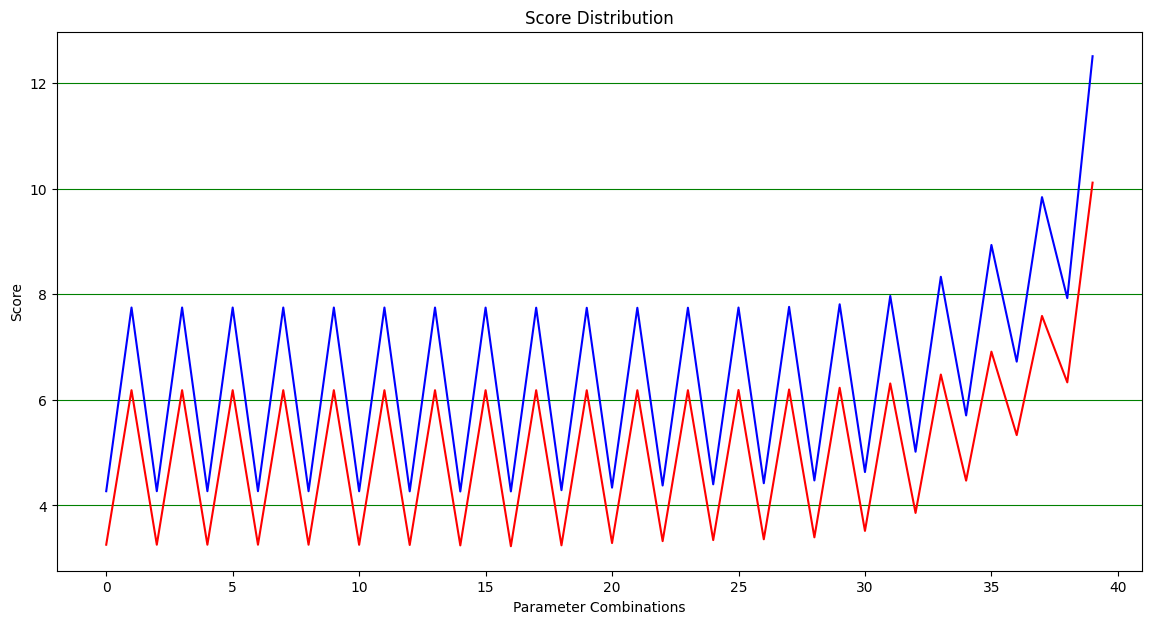

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler()
Xtrain_minmax = scaler_minmax.fit_transform(Xtrain)
Xval_minmax = scaler_minmax.transform(Xval)

ridge_best_parameters(Xtrain_minmax,Xval_minmax)

### Scaling Features with StandardScaler

#### Steps:
1. **Initialize the Scaler**:
   - `StandardScaler()` is initialized to standardize the features.

2. **Fit and Transform Training Data**:
   - `fit_transform` is applied to `Xtrain` to compute the mean and standard deviation for scaling and to standardize the training data.

3. **Transform Validation Data**:
   - The previously computed mean and standard deviation are applied to `Xval` using `transform` to ensure consistent scaling.

4. **Hyperparameter Tuning with Scaled Data**:
   - The standardized datasets (`Xtrain_standard` and `Xval_standard`) are passed to the `ridge_best_parameters` function to perform hyperparameter tuning.

#### Code Workflow:
- StandardScaler centers the data around zero with a unit standard deviation.
- Ensures that all features contribute equally to the model by eliminating the effects of differing feature scales.
- Ideal for Ridge Regression and other models sensitive to feature variance.


Found best RMSE score 4.265222259541005
 parametrs : {'fit_intercept': True, 'alpha': np.float64(1.438449888287663)}
Found best MAE score 3.2331962726496104
 parametrs : {'fit_intercept': True, 'alpha': np.float64(1.438449888287663)}


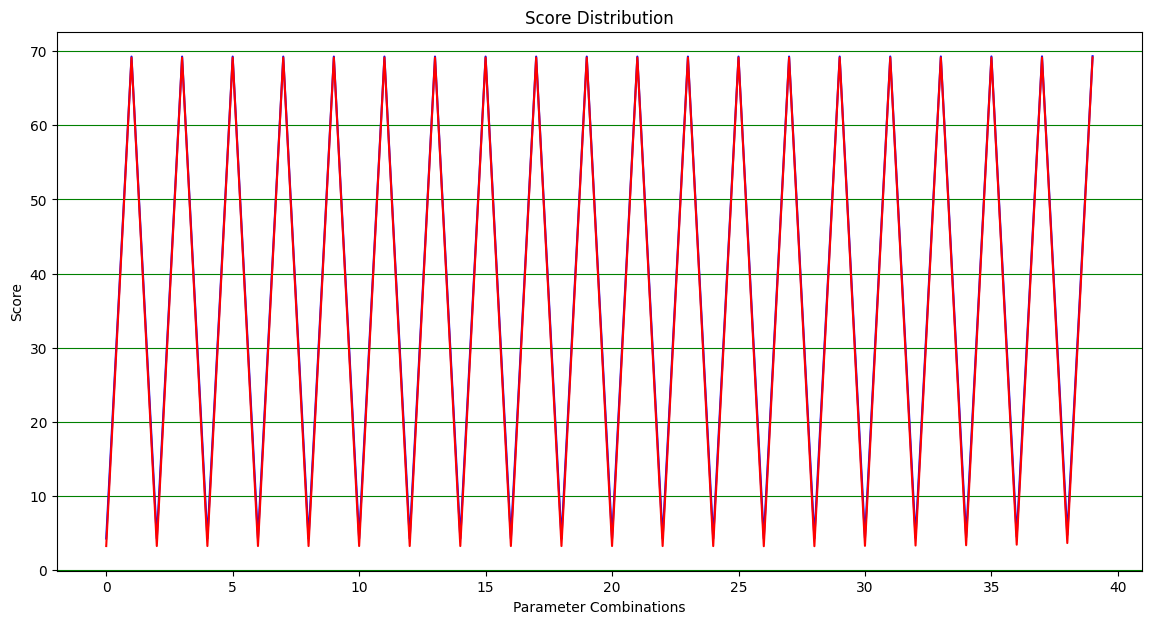

In [14]:
from sklearn.preprocessing import StandardScaler

scaler_standard = StandardScaler()
Xtrain_standard = scaler_standard.fit_transform(Xtrain)
Xval_standard = scaler_standard.transform(Xval)
ridge_best_parameters(Xtrain_standard,Xval_standard)

### Hyperparameter Tuning for Custom Random Forest

Found best RMSE score 2.1579378753091
 parametrs {'n_estimators': 61, 'max_samples': np.float64(0.7000000000000001), 'max_depth': 7}
Found best MAE score 1.50677728188537
 parametrs {'n_estimators': 41, 'max_samples': np.float64(0.7000000000000001), 'max_depth': 7}


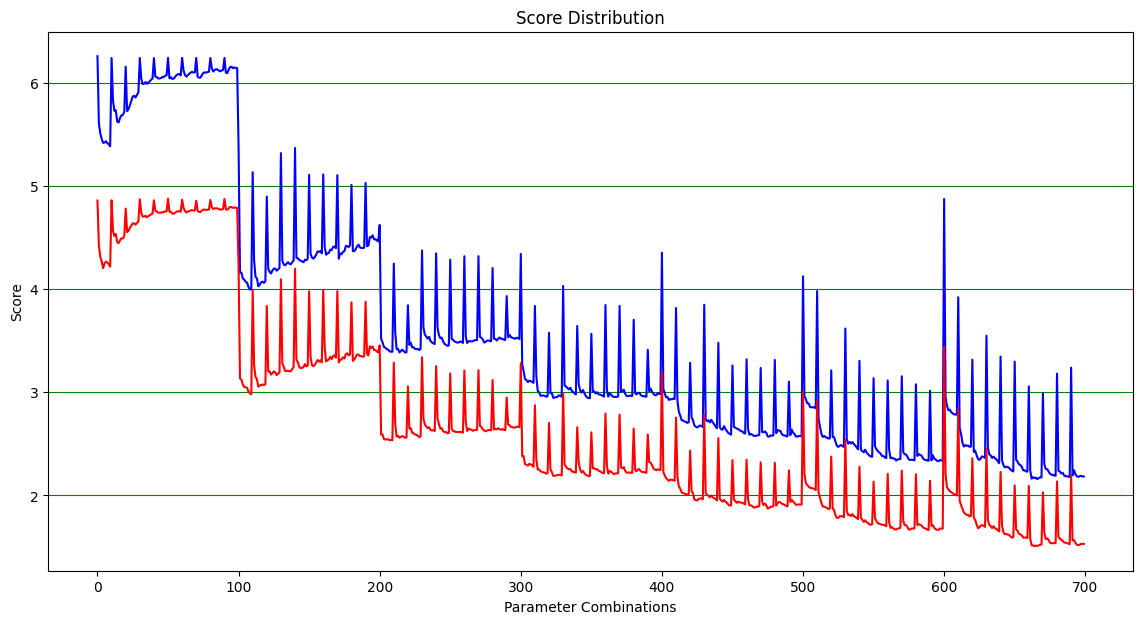

In [15]:
forest_best_parameters(Xtrain, Xval)

### Hyperparameter Tuning for AdaBoost Regressor

Found best RMSE score 1.827710125915935
 parametrs: {'n_estimators': 75, 'max_depth': 9}
Found best MAE score 1.2269435955639
 parametrs: {'n_estimators': 75, 'max_depth': 9}


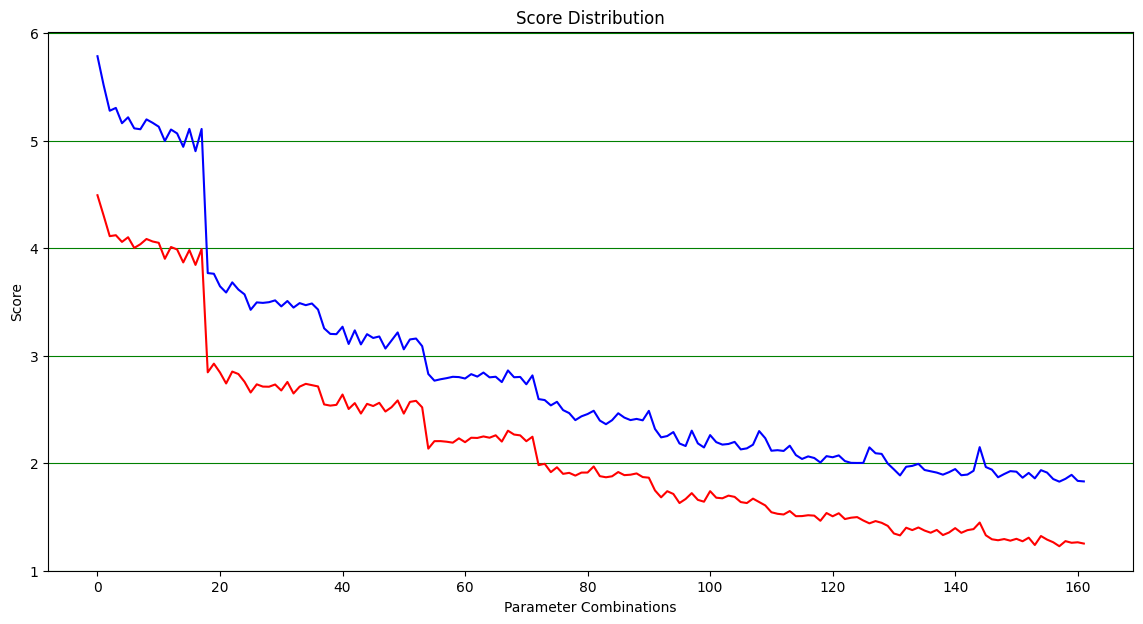

In [16]:
adaboost_best_parameters(Xtrain,Xval)

### AdaBoost Regression showed the best results on validation data:
- `Found best RMSE score` 1.827710125915935
- `Parametrs`: {'n_estimators': 75, 'max_depth': 9}

In [17]:
evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          210 non-null    int8   
 1   Year                             210 non-null    int64  
 2   Status                           210 non-null    int8   
 3   Adult Mortality                  210 non-null    float64
 4   infant deaths                    210 non-null    int64  
 5   Alcohol                          210 non-null    float64
 6   percentage expenditure           210 non-null    float64
 7   Hepatitis B                      210 non-null    float64
 8   Measles                          210 non-null    int64  
 9   BMI                              210 non-null    float64
 10  under-five deaths                210 non-null    int64  
 11  Polio                            210 non-null    float64
 12  Total expenditure     

### Final Model Training and Predictions

This code trains the **AdaBoost Regressor** with the best hyperparameters and uses it to make predictions on the evaluation dataset.

#### Steps:

1. **Initialize the Model**:
   - **AdaBoost Regressor** is initialized with:
     - `n_estimators`: 75 (number of boosting stages).
     - `estimator`: A `DecisionTreeRegressor` with `max_depth=9` (used as the base learner).

2. **Train the Model**:
   - The model is trained on the `Xtrain` and `ytrain` datasets.

3. **Make Predictions**:
   - Predictions are generated for the `evaluation` dataset using the trained AdaBoost Regressor.

4. **Prepare the Results**:
   - A DataFrame is created with the following columns:
     - `'Country'`: Extracted from the `evaluation_country` variable.
     - `'Year'`: Extracted from the `Year` column of the `evaluation` dataset.
     - `'Life expectancy'`: The predicted values from the model.

5. **Save the Results**:
   - The DataFrame is saved as a CSV file named `results.csv`.


In [18]:
best_regression = AdaBoostRegressor(n_estimators=75,
                                    estimator=DecisionTreeRegressor(max_depth = 9))
best_regression.fit(Xtrain,ytrain)
evaluation_prediction = best_regression.predict(evaluation)
results = pd.DataFrame({
    'Country': evaluation_country,
    'Year': evaluation['Year'],
    'Life expectancy': evaluation_prediction
})

results.to_csv('results.csv', index=False)